In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from matchms.importing import load_from_json
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt 

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)
sys.path.insert(0, os.path.join(ROOT, "ms2deepscore"))
path_data_gnps = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\matchms\\data\\'
path_data = 'C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA\\ms2deepscore\\data\\'

## Define functions to make spectrum vector for ML model

In [2]:
from utils import create_peak_dict
from spectrum_binning_fixed import create_peak_list_fixed, unique_peaks_fixed, set_d_bins_fixed

## Load spectra

In [3]:
outfile = os.path.join(path_data_gnps,'gnps_positive_ionmode_annotated_w_fps_processed.pickle')
with open(outfile, 'rb') as file:
    spectrums_annotated = pickle.load(file)

In [4]:
metadata_file = os.path.join(path_data, "metadata_AllInchikeys.csv")
metadata = pd.read_csv(metadata_file)
metadata.head()

,Unnamed: 0,inchikey,inchi,ID
0,0,MYHSVHWQEVDFQT-RLIDIOMENA-N,InChI=1/C11H19NO10S2/c1-2-5(14)3-7(12-22-24(18...,75971
1,1,BKAWJIRCKVUVED-UHFFFAOYSA-N,"InChI=1S/C6H9NOS/c1-5-6(2-3-8)9-4-7-5/h4,8H,2-...",17330
2,2,CXVGEDCSTKKODG-UHFFFAOYSA-N,InChI=1S/C14H12O6S/c1-20-12-8-11(15)10(7-13(12...,422
3,3,JAMSDVDUWQNQFZ-QNQJCTKXSA-N,InChI=1S/C52H102NO8P/c1-6-8-10-12-14-16-18-20-...,38937
4,4,ODHCTXKNWHHXJC-GSVOUGTGSA-N,"InChI=1S/C5H7NO3/c7-4-2-1-3(6-4)5(8)9/h3H,1-2H...",46378


In [10]:
metadata_testing = metadata.copy()["inchikey"][:100]
np.save("testdata_inchikey_score_mapping.npy", metadata_testing.values)

In [14]:
test_data_spectrum = []
for spec in spectrums_annotated:
    if spec.get("inchikey") in metadata_testing.values:
        test_data_spectrum.append(spec)

In [5]:
metadata.values[np.where(metadata.inchikey == "ODHCTXKNWHHXJC-GSVOUGTGSA-N")][0][0]

4

In [6]:
metadata.shape

(14459, 4)

### Load reference scores (Tanimoto)

In [11]:
filename = os.path.join(path_data,'similarities_AllInchikeys_daylight2048_jaccard.npy')
scores_mol_similarity = np.load(filename)

In [12]:
scores_mol_similarity.shape

(14459, 14459)

In [13]:
np.save("testdata_tanimoto_scores.npy", scores_mol_similarity[:100, :100])

In [12]:
ID = 100
np.where((scores_mol_similarity[ID,:] > 0.7) & (scores_mol_similarity[ID,:] < 0.99))[0]

array([ 3339,  5594, 10540], dtype=int64)

In [13]:
metadata.loc[ID]["inchi"], metadata.loc[3339]["inchi"]

('InChI=1S/C20H39NO4S/c1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-20(22)21-18-19-26(23,24)25/h9-10H,2-8,11-19H2,1H3,(H,21,22)(H,23,24,25)/b10-9-',
 'InChI=1S/C21H41NO4S/c1-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-21(23)22(2)19-20-27(24,25)26/h10-11H,3-9,12-20H2,1-2H3,(H,24,25,26)/b11-10-')

## Build data pipeline for training on AllInchikeys dataset
### Split dataset into train/val/test

In [9]:
split_ratio = (0.9, 0.05, 0.05)

np.random.seed(111)

N_label = metadata.shape[0]
idx = np.arange(0, N_label)
N_train = int(split_ratio[0] * N_label)
N_val = int(split_ratio[1] * N_label)
N_test = N_label - N_train - N_val
print("Split dataset into train/val/test fractions:", N_train, N_val, N_test)

# Select training, validation, and test IDs:
trainIDs = np.random.choice(idx, N_train, replace=False)
valIDs = np.random.choice(list(set(idx) - set(trainIDs)), N_val, replace=False)
testIDs = list(set(idx) - set(trainIDs) - set(valIDs))

Split dataset into train/val/test fractions: 13013 722 724


In [10]:
inchikeys_list = []
for s in spectrums_annotated:
    inchikeys_list.append(s.get("inchikey"))

inchikeys_array = np.array(inchikeys_list)

In [11]:
a = np.where(inchikeys_array == metadata.loc[4].inchikey)[0]
list(a) + list(a)


[46378, 46379, 46378, 46379]

In [12]:
train_IDs_all = []
for ID in trainIDs:
    inchikey = metadata.loc[ID].inchikey
    train_IDs_all += list(np.where(inchikeys_array == inchikey)[0])
    
len(train_IDs_all)

69959

In [13]:
val_IDs_all = []
for ID in valIDs:
    inchikey = metadata.loc[ID].inchikey
    val_IDs_all += list(np.where(inchikeys_array == inchikey)[0])
    
len(val_IDs_all)

3469

In [14]:
test_IDs_all = []
for ID in testIDs:
    inchikey = metadata.loc[ID].inchikey
    test_IDs_all += list(np.where(inchikeys_array == inchikey)[0])
    
len(test_IDs_all)

3663

In [15]:
trainIDs[:10], train_IDs_all[:10]

(array([11925,  2413, 13459, 12783, 13292,  1785, 13828,   637,  7179,
        10400]),
 [9067, 9068, 58044, 58045, 58046, 58047, 58048, 58049, 58050, 58051])

In [16]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import Sequence


class DataGenerator_all(Sequence):
    """Generates data for training a siamese Keras model
    """
    def __init__(self, spectrums_binned_dicts: list, list_IDs: list, list_score_IDs: list,
                 score_array: np.ndarray = None, batch_size: int = 32, num_turns: int = 1,
                 peak_scaling: float = 0.5,
                 dim: tuple = (10000,1), shuffle: bool = True, ignore_equal_pairs: bool = True,
                 inchikeys_array: np.ndarray = None, inchikey_mapping: pd.DataFrame = None,
                 same_prob_bins: list = [(0, 0.5), (0.5, 1)],
                 augment_peak_removal: dict = {"max_removal": 0.2, "max_intensity": 0.2},
                 augment_intensity: float = 0.1):
        """Generates data for training a siamese Keras model

        Parameters
        ----------
        spectrums_binned_dicts
            List of dictionaries with the binned peak positions and intensities.
        list_IDs
            List of IDs from the spectrums_binned_dicts list to use for training
        score_array
            Array of reference similarity scores (=labels).
        batch_size
            Number of pairs per batch. Default=32.
        num_turns
            Number of pairs for each InChiKey during each epoch. Default=1
        peak_scaling
            Scale all peak intensities by power pf peak_scaling. Default is 0.5.
        dim
            Input vector dimension. Default=(10000,1)
        shuffle
            Set to True to shuffle IDs every epoch. Default=True
        ignore_equal_pairs
            Set to True to ignore pairs of two identical spectra. Default=True
        inchikeys_array
        inchikey_mapping
        same_prob_bins
        augment_peak_removal
            Dictionary with two parameters. max_removal specifies the maximum amount
            of peaks to be removed (random fraction between 0 and max_removal), and
            max_intensity specifying that only peaks < max_intensity will be removed.
        augment_intensity
            Change peak intensities by a random number between 0 and augment_intensity.
            Default=0.1, which means that intensities are multiplied by 1+- a random
            number within [0, 0.1].

        """
        self.spectrums_binned_dicts = spectrums_binned_dicts
        assert score_array is not None, "needs score array"
        self.score_array = score_array
        self.score_array[np.isnan(score_array)] = 0
        self.list_IDs = list_IDs
        self.list_score_IDs = list_score_IDs
        self.dim = dim
        self.batch_size = batch_size
        self.num_turns = num_turns #number of go's through all IDs
        self.peak_scaling = peak_scaling
        self.shuffle = shuffle
        self.ignore_equal_pairs = ignore_equal_pairs
        self.on_epoch_end()
        assert inchikey_mapping is not None, "needs inchikey mapping"
        self.inchikey_mapping = inchikey_mapping
        self.inchikeys_array = inchikeys_array
        self.same_prob_bins = same_prob_bins
        self.augment_peak_removal = augment_peak_removal
        self.augment_intensity = augment_intensity

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(self.num_turns) * int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        # Go through all indexes
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Select subset of IDs
        list_IDs_temp = []
        for index in indexes:
            ID1 = self.list_IDs[index]
            prob_bins = self.same_prob_bins[np.random.choice(np.arange(len(self.same_prob_bins)))]
            inchikey1 = self.inchikeys_array[ID1]
            #ID1_score = int(self.inchikey_mapping[self.inchikey_mapping == inchikey1].index[0])
            ID1_score = self.inchikey_mapping.values[np.where(self.inchikey_mapping.inchikey == inchikey1)][0][0]
            
            extend_range = 0
            while extend_range < 0.4:
                idx = np.where((self.score_array[ID1_score, self.list_score_IDs] > prob_bins[0] - extend_range)
                               & (self.score_array[ID1_score, self.list_score_IDs] <= prob_bins[1] + extend_range))[0]
                #if self.ignore_equal_pairs:
                #    idx = idx[idx != ID1]
                if len(idx) > 0:
                    ID2_score = self.list_score_IDs[np.random.choice(idx)]
                    break
                extend_range += 0.1

            if len(idx) == 0:
                #print(f"No matching pair found for score within {(prob_bins[0]-extend_range):.2f} and {(prob_bins[1]+extend_range):.2f}")
                #print(f"ID1: {ID1}")
                second_highest_id = self.score_array[ID1_score, np.array([x for x in self.list_score_IDs if x != ID1_score])].argmax()
                if second_highest_id > ID1_score:
                    second_highest_id += 1
                ID2_score = self.list_score_IDs[second_highest_id]
                #print(f"Picked ID2: {ID2}")
            
            # Get ID2 based on InchiKey
            inchikey2 = self.inchikey_mapping.loc[ID2_score]["inchikey"]
            idx2 = np.where(self.inchikeys_array == inchikey2)[0]
            if len(idx2) > 1 and self.ignore_equal_pairs:
                ID2 = np.random.choice([x for x in idx2 if x != ID1])
            else:
                ID2 = np.random.choice(idx2) 
            list_IDs_temp.append((ID1, ID2, ID1_score, ID2_score))

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.tile(np.arange(len(self.list_IDs)), int(self.num_turns))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_augmentation(self, document_dict):
        """Data augmentation."""
        idx = np.array([x for x in document_dict.keys()])
        values = np.array([x for x in document_dict.values()])
        if self.augment_peak_removal:
            indices_select = np.where(values < self.augment_peak_removal["max_intensity"])[0]
            removal_part = np.random.random(1) * self.augment_peak_removal["max_removal"]
            indices_select = np.random.choice(indices_select,
                                              int(np.ceil((1 - removal_part)*len(indices_select))))
            indices = np.concatenate((indices_select,
                                      np.where(values >= self.augment_peak_removal["max_intensity"])[0]))
            if len(indices) > 0:
                idx = idx[indices]
                values = values[indices]
        if self.augment_intensity:
            values = (1 - self.augment_intensity * 2 * (np.random.random(values.shape) - 0.5)) * values
        return idx, values


    def __data_generation(self, list_IDs_temp):
        """Generates data containing batch_size samples"""
        # Initialization
        X = [np.zeros((self.batch_size, self.dim)) for i in range(2)]
        y = np.zeros((self.batch_size,))

        # Generate data
        for i, IDs in enumerate(list_IDs_temp):
            ID1, ID2, ID1_score, ID2_score = IDs
            ref_idx, ref_values = self.__data_augmentation(self.spectrums_binned_dicts[ID1])

            # Add scaled weight to right bins
            X[0][i, ref_idx] = ref_values ** self.peak_scaling
            query_idx, query_values = self.__data_augmentation(self.spectrums_binned_dicts[ID2])

            # Add scaled weight to right bins
            X[1][i, query_idx] = query_values ** self.peak_scaling
            y[i] = self.score_array[ID1_score, ID2_score]
            if np.isnan(y[i]):
                y[i] = np.random.random(1)
        return X, y

## Convert spectra into binned spectra and peak dicts (FIXED BINS)

In [15]:
from spectrum_binning_fixed import create_peak_list_fixed, set_d_bins_fixed, unique_peaks_fixed

In [16]:
# Set binning --> FIXED BINS --> HERE ONLY FOR TESTING
number_of_bins = 100
mz_max = 1000.0
mz_min = 10.0

d_bins = set_d_bins_fixed(number_of_bins, mz_min=mz_min, mz_max=mz_max)
print("d_bins:", d_bins)

class_values, unique_peaks = unique_peaks_fixed(test_data_spectrum, d_bins, mz_min)
vector_dim = len(unique_peaks)
print("Vector dimension:", vector_dim)

spectrums_binned = create_peak_list_fixed(test_data_spectrum, class_values,
                                          d_bins, mz_min=mz_min)
spectrums_binned_dicts = [create_peak_dict(spec) for spec in spectrums_binned]

d_bins: 9.9
Vector dimension: 101


In [19]:
len(spectrums_binned_dicts)

334

In [21]:
import json
with open('testdata_spectrums_binned.json', 'w') as fout:
    json.dump(spectrums_binned_dicts, fout)

In [23]:
inchikeys_list = []
for s in test_data_spectrum:
    inchikeys_list.append(s.get("inchikey"))

inchikeys_array = np.array(inchikeys_list)
np.save("testdata_inchikeys.npy", inchikeys_array)

In [18]:
# Set binning --> FIXED BINS
number_of_bins = 12000
mz_max = 1000.0
mz_min = 10.0

d_bins = set_d_bins_fixed(number_of_bins, mz_min=mz_min, mz_max=mz_max)
print("d_bins:", d_bins)

d_bins: 0.0825


In [19]:
class_values, unique_peaks = unique_peaks_fixed(spectrums_annotated, d_bins, mz_min)
vector_dim = len(unique_peaks)
print("Vector dimension:", vector_dim)

Vector dimension: 11995


In [22]:
# just checking...
from spectrum_binning_fixed import bin_number_fixed, bin_number_array_fixed
mz = np.array([10, 10.051, 10.11, 10.2, 15, 100, 1000])
bin_number_array_fixed(mz, d_bins, mz_min=mz_min)

array([    0,     0,     1,     2,    60,  1091, 12000])

In [23]:
spectrums_binned = create_peak_list_fixed(spectrums_annotated, class_values,
                                          d_bins, mz_min=mz_min)
spectrums_binned_dicts = [create_peak_dict(spec) for spec in spectrums_binned]

In [24]:
count_bin_filling = []
for spec in spectrums_binned[:1000]:
    count_bin_filling += [x[0] for x in spec]

(array([ 25054.,  59444.,  67657.,  65491.,  73249., 103318.,  91656.,
         74042.,  63219.,  57367.,  52124.,  47288.,  44942.,  41878.,
         40821.,  37018.,  27067.,  23801.,  21078.,  17127.,  14691.,
         11284.,   9830.,   9076.,   8466.]),
 array([  119.,   594.,  1069.,  1544.,  2019.,  2494.,  2969.,  3444.,
         3919.,  4394.,  4869.,  5344.,  5819.,  6294.,  6769.,  7244.,
         7719.,  8194.,  8669.,  9144.,  9619., 10094., 10569., 11044.,
        11519., 11994.]),
 <BarContainer object of 25 artists>)

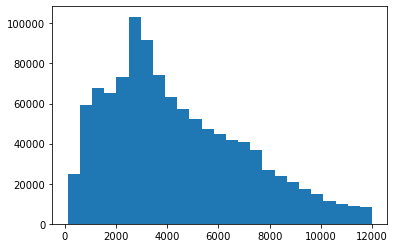

In [25]:
plt.hist(count_bin_filling, 25)

## Data generator for more balanced training data

In [23]:
#from data_generators import DataGenerator_all

In [26]:
same_prob_bins = list(zip(0.1*np.arange(10), (0.1 + 0.1*np.arange(10))))

train_generator = DataGenerator_all(spectrums_binned_dicts, train_IDs_all, trainIDs, 
                                              score_array=scores_mol_similarity, peak_scaling=0.5,
                                              batch_size=25, num_turns=1, dim=(vector_dim), shuffle=True,
                                              ignore_equal_pairs=True,
                                              inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                              same_prob_bins=same_prob_bins,
                                              augment_peak_removal={"max_removal": 0.3, "max_intensity": 0.2},
                                              augment_intensity=0.4)

val_generator = DataGenerator_all(spectrums_binned_dicts, val_IDs_all, valIDs, 
                                            score_array=scores_mol_similarity, peak_scaling=0.5,
                                            batch_size=25, num_turns=1, dim=(vector_dim), shuffle=True,
                                            ignore_equal_pairs=True,
                                            inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                            same_prob_bins=same_prob_bins,
                                            augment_peak_removal={"max_removal": 0.01, "max_intensity": 0.01},
                                            augment_intensity=0.1)

In [27]:
A, B = val_generator.__getitem__(4)
A[0].shape, A[1].shape, B

((25, 11995),
 (25, 11995),
 array([1.        , 0.45666667, 0.3803132 , 0.32597055, 0.13018322,
        1.        , 0.35445545, 0.11864407, 0.46923077, 0.62075472,
        0.53289474, 0.24877365, 0.09312169, 0.06245297, 0.48887476,
        0.14648438, 0.24581818, 0.22942643, 0.33059418, 1.        ,
        0.23762376, 0.40231548, 1.        , 0.48297872, 0.43676572]))

## Deep learning network
- score based on cosine similarity layer
- large network
- L1 regularization + dropout + data augmentation to enforce better generalization
- relu activations for creating embeddings (tanh activation wasn't very good!)

In [28]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Subtract, Lambda, Concatenate, \
    GaussianNoise, Dot, Dropout, BatchNormalization
from tensorflow.keras.models import Model

In [29]:
dense_dims = [700, 600, 500, 500, 400]
dropout_rate = 0.25
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)

encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104",
                 #activity_regularizer=tf.keras.regularizers.l2(0.001),
                )(encoding)
#encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[4], activation = 'relu', name="embedding")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(1, 1), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 11995
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 11995)]      0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 11995)]      0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 400)          9573600     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1)            0         

In [30]:
epochs = 150
learning_rate = 0.002 #0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 10
scoring_network_output_file = "scoring_network_201122_All_cosine_large_fixedBins.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
2798/2798 [==============================] - ETA: 0s - loss: 0.1465 - mae: 0.2040
Epoch 00001: val_loss improved from inf to 0.13225, saving model to scoring_network_201122_All_cosine_large_fixedBins.hdf5
2798/2798 [==============================] - 964s 344ms/step - loss: 0.1465 - mae: 0.2040 - val_loss: 0.1322 - val_mae: 0.1859
Epoch 2/150
2798/2798 [==============================] - ETA: 0s - loss: 0.1232 - mae: 0.1838
Epoch 00002: val_loss improved from 0.13225 to 0.12292, saving model to scoring_network_201122_All_cosine_large_fixedBins.hdf5
2798/2798 [==============================] - 926s 331ms/step - loss: 0.1232 - mae: 0.1838 - val_loss: 0.1229 - val_mae: 0.1875
Epoch 3/150
2798/2798 [==============================] - ETA: 0s - loss: 0.1113 - mae: 0.1772
Epoch 00003: val_loss improved from 0.12292 to 0.11292, saving model to scoring_network_201122_All_cosine_large_fixedBins.hdf5
2798/2798 [

Epoch 26/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0612 - mae: 0.1375
Epoch 00026: val_loss did not improve from 0.06896
2798/2798 [==============================] - 879s 314ms/step - loss: 0.0612 - mae: 0.1375 - val_loss: 0.0716 - val_mae: 0.1587
Epoch 27/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0600 - mae: 0.1361
Epoch 00027: val_loss did not improve from 0.06896
2798/2798 [==============================] - 882s 315ms/step - loss: 0.0600 - mae: 0.1361 - val_loss: 0.0711 - val_mae: 0.1562
Epoch 28/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0605 - mae: 0.1376
Epoch 00028: val_loss did not improve from 0.06896
2798/2798 [==============================] - 875s 313ms/step - loss: 0.0605 - mae: 0.1376 - val_loss: 0.0700 - val_mae: 0.1551
Epoch 29/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0597 - mae: 0.1355
Epoch 00029: val_loss improved from 0.06896 to 0.06812, saving model to scoring_networ

Epoch 55/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0553 - mae: 0.1288
Epoch 00055: val_loss improved from 0.06534 to 0.06469, saving model to scoring_network_201122_All_cosine_large_fixedBins.hdf5
2798/2798 [==============================] - 1239s 443ms/step - loss: 0.0553 - mae: 0.1288 - val_loss: 0.0647 - val_mae: 0.1461
Epoch 56/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0555 - mae: 0.1287
Epoch 00056: val_loss did not improve from 0.06469
2798/2798 [==============================] - 1075s 384ms/step - loss: 0.0555 - mae: 0.1287 - val_loss: 0.0649 - val_mae: 0.1492
Epoch 57/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0557 - mae: 0.1289
Epoch 00057: val_loss did not improve from 0.06469
2798/2798 [==============================] - 1020s 365ms/step - loss: 0.0557 - mae: 0.1289 - val_loss: 0.0652 - val_mae: 0.1465
Epoch 58/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0552 - mae: 0.1280
Epoch 0

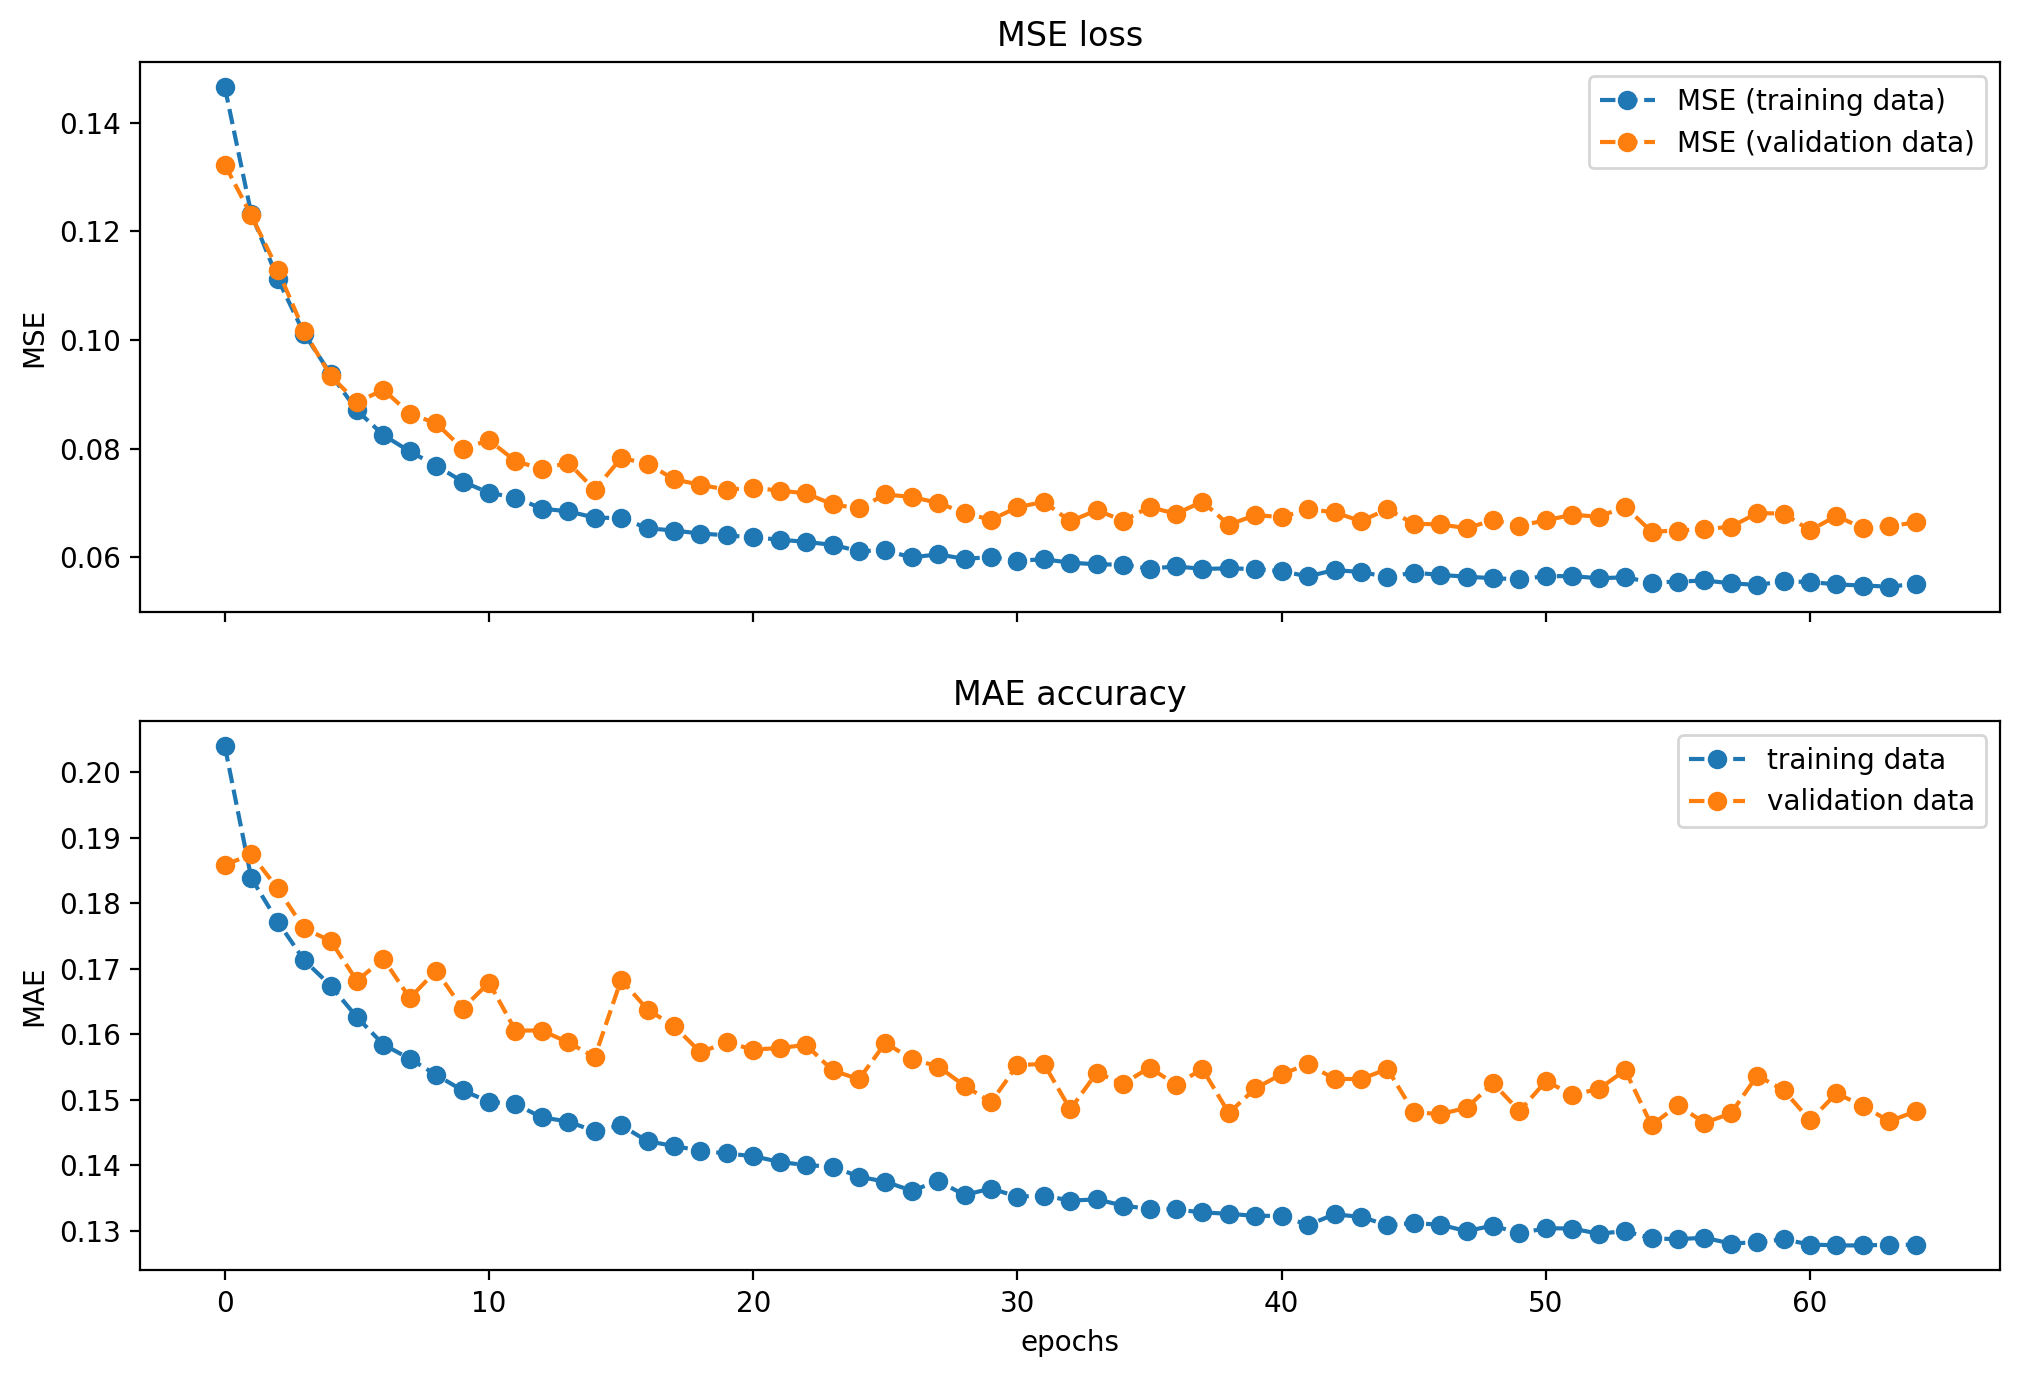

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [33]:
A, B = val_generator.__getitem__(0)
A[0].shape, A[1].shape, B

((25, 11995),
 (25, 11995),
 array([0.0799373 , 0.42939815, 0.31093544, 0.09489051, 0.31481481,
        0.28005464, 0.55478502, 0.54401583, 0.31188659, 0.58995816,
        1.        , 0.46712803, 0.41622691, 1.        , 0.17573529,
        0.6039501 , 0.08241206, 0.4516129 , 0.06700288, 0.13818861,
        0.50409836, 0.53204476, 1.        , 0.38499385, 0.08307692]))

In [58]:
y_pred = scoring_network.predict([A[0], A[1]])
y_pred[:,0]

array([0.42926013, 0.24663001, 0.5998888 , 0.99932766, 0.15947022,
       0.1217737 , 0.9980104 , 0.07695198, 0.6579709 , 0.9901054 ,
       0.21728238, 0.6365901 , 0.30950856, 0.09628874, 0.42644143,
       0.97500694, 0.6062038 , 0.33120492, 0.33196598, 0.05338394,
       0.6710181 , 0.99981856, 0.24758115, 0.33997217, 0.9788577 ],
      dtype=float32)

In [34]:
encoder.predict(A[0][0, :].reshape(1,-1))

array([[   0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      , 2837.649   ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,  790.55865 ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
        4637.972   ,    0.      ,    0.      ,    0.      , 2019.431   ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
        3207.9924  ,    0.      ,    0.      ,   96.731186,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0.      ,    0.      ,
           0.      ,    0.      ,    0.      ,    0

In [35]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
from tqdm import tqdm

def get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list, peak_scaling=0.5):
    
    input_dim = encoder.input_shape[1]
    embeddings = np.zeros((len(IDs), embedding_dim))
    for i, ID in enumerate(tqdm(IDs)):
        X = np.zeros((1, input_dim))
        inchikey = inchikey_mapping.loc[ID]["inchikey"]
        ID1_all = np.where(inchikey_list == inchikey)[0][0]
        idx = np.array([x for x in spectrums_binned_dicts[ID1_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID1_all].values()]) ** peak_scaling
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array(testIDs, 400, encoder, metadata, inchikeys_array, peak_scaling=0.5)

100%|████████████████████████████████████████████████████████████████████████████████| 724/724 [01:42<00:00,  7.07it/s]


In [36]:
from matchms.similarity.vector_similarity_functions import cosine_similarity_matrix, cosine_similarity

MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [37]:
scores_ref = scores_mol_similarity[np.ix_(testIDs[:], testIDs[:])].copy()

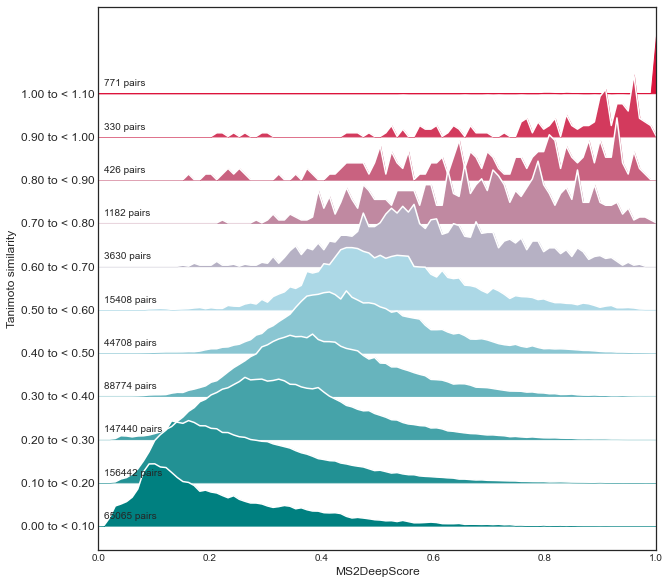

In [38]:
from plotting import create_histograms_plot

create_histograms_plot(scores_ref, MS2DS_scores, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

# Plot all test spectra (multiple for many Inchikeys)

In [39]:
#def create_similarity_matrix(IDs, embedding_dim, encoder, inchikey_mapping, inchikey_list):
from tqdm import tqdm

def get_embedding_array_all(IDs_all, embedding_dim, encoder, peak_scaling=0.5):
    
    input_dim = encoder.input_shape[1]
    embeddings = np.zeros((len(IDs_all), embedding_dim))
    for i, ID_all in enumerate(tqdm(IDs_all)):
        X = np.zeros((1, input_dim))
        idx = np.array([x for x in spectrums_binned_dicts[ID_all].keys()])
        X[0, idx] = np.array([x for x in spectrums_binned_dicts[ID_all].values()]) ** peak_scaling
        embeddings[i, :] = encoder.predict(X)

    return embeddings

embeddings = get_embedding_array_all(test_IDs_all, 400, encoder, peak_scaling=0.5)

100%|██████████████████████████████████████████████████████████████████████████████| 3663/3663 [04:59<00:00, 12.23it/s]


In [40]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

In [41]:
test_IDs_to_meta = []
for ID in test_IDs_all:
    inchikey = inchikeys_array[ID]
    id_meta = metadata[metadata["inchikey"] == inchikey].index[0]
    test_IDs_to_meta.append(id_meta)

In [42]:
scores_ref = scores_mol_similarity[np.ix_(test_IDs_to_meta[:], test_IDs_to_meta[:])].copy()

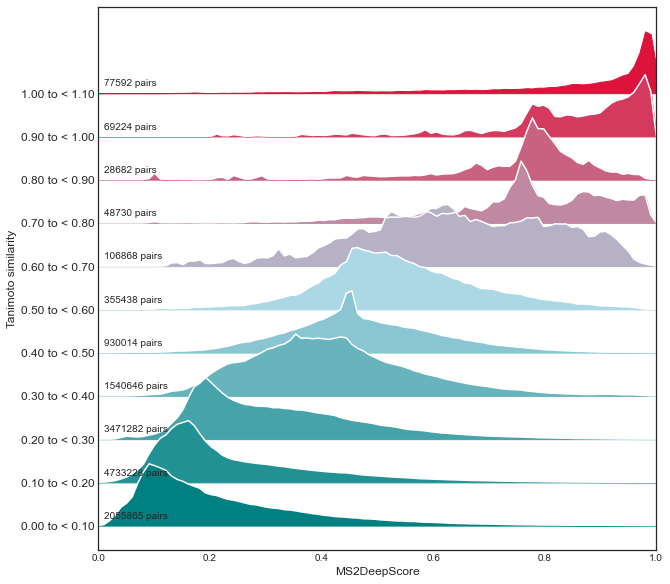

In [43]:
create_histograms_plot(scores_ref, MS2DS_scores, n_bins=10, hist_resolution=100,
                          ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

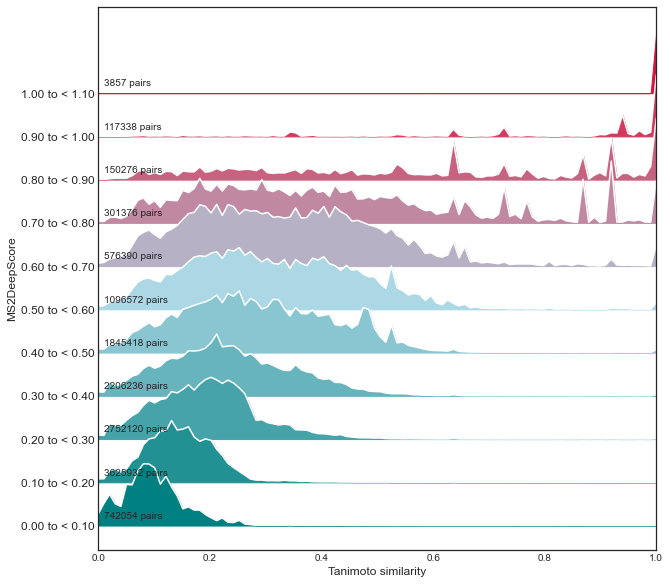

In [44]:
create_histograms_plot(MS2DS_scores, scores_ref, n_bins=10, hist_resolution=100,
                      ref_score_name="MS2DeepScore", compare_score_name="Tanimoto similarity")

# Ensemble model (monte carlo dropout)

In [45]:
dense_dims = [700, 600, 500, 500, 400]
dropout_rate = 0.25
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)

encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding, training=True)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding, training=True)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104",
                 #activity_regularizer=tf.keras.regularizers.l2(0.001),
                )(encoding)
#encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[4], activation = 'relu', name="embedding")(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(1, 1), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network_ensemble = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])
# Transfer weights
scoring_network_ensemble.set_weights(scoring_network.get_weights())

scoring_network_ensemble.summary()

Vector dimension: 11995
Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 11995)]      0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 11995)]      0                                            
__________________________________________________________________________________________________
functional_5 (Functional)       (None, 400)          9573600     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1)            0         

In [54]:
#from tqdm import tqdm
from tqdm.notebook import tqdm

def ensemble_scoring(IDs, embedding_dim, encoder, inchikey_mapping, inchikeys_array,
                     n_ensembles=5, peak_scaling=0.5):
    """All-vs-All scoring"""
    dim = len(IDs)
    
    print(f"Calculating matrix of {dim}x{dim} similarity scores and STD.")
    print(f"Ensembling over {n_ensembles} embeddings (={n_ensembles**2} pairs).")
    
    embeddings = np.zeros((n_ensembles, dim, embedding_dim))
    for i in tqdm(range(n_ensembles)):
        embeddings[i, :, :] = get_embedding_array(IDs, embedding_dim, encoder, inchikey_mapping,
                                                  inchikeys_array, peak_scaling=peak_scaling)
    
    scores = np.zeros((dim, dim))
    scores_std = np.zeros((dim, dim))

    for i in tqdm(range(dim)):
        for j in range(i, dim):
            scores_ensemble = cosine_similarity_matrix(embeddings[:, i, :], embeddings[:, j, :])
            scores[i, j] = scores[j, i] = scores_ensemble.mean()
            scores_std[i, j] = scores_std[j, i] = scores_ensemble.std()
    return scores, scores_std

In [55]:
embedding_dim = 400
scores, scores_std = ensemble_scoring(testIDs, embedding_dim, encoder,
                                      metadata, inchikeys_array, n_ensembles=7)

Calculating matrix of 724x724 similarity scores and STD.
Ensembling over 7 embeddings (=49 pairs).


In [52]:
scores_std.mean(), scores_std.max()

(0.024467736469053092, 0.0635961774596048)

Text(0, 0.5, 'number of instances')

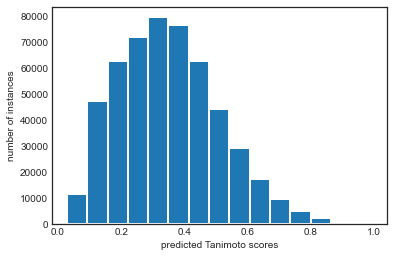

In [70]:
plt.hist(scores.reshape(-1), 15, edgecolor='white', linewidth=2)
plt.xlabel("predicted Tanimoto scores")
plt.ylabel("number of instances")

Text(0, 0.5, 'number of instances')

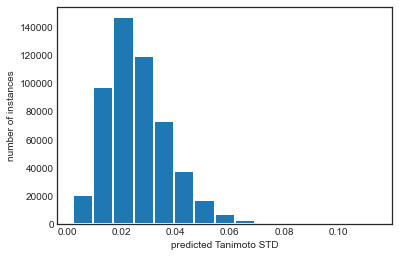

In [71]:
plt.hist(scores_std.reshape(-1), 15, edgecolor='white', linewidth=2)
plt.xlabel("predicted Tanimoto STD")
plt.ylabel("number of instances")

In [ ]:
scores_ref = scores_mol_similarity[np.ix_(testIDs[:], testIDs[:])].copy()

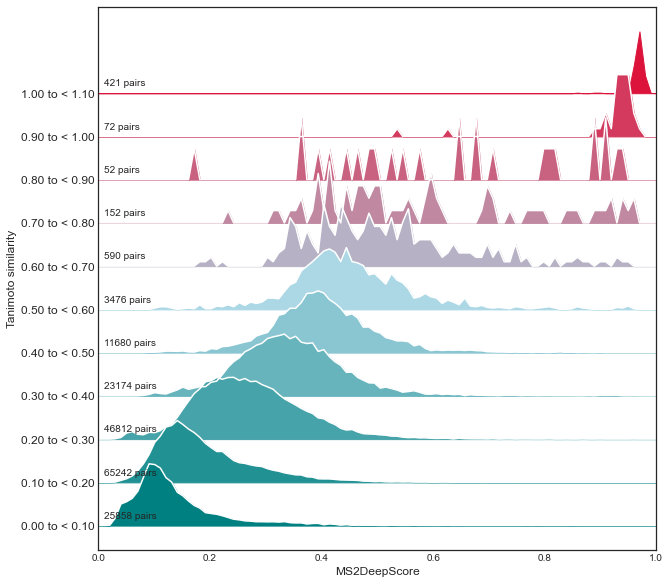

In [73]:
threshold = 0.02

create_histograms_plot(scores_ref[scores_std < threshold], scores[scores_std < threshold], n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\ms2deepscore\ms2deepscore\plotting.py:48: RuntimeWarning: invalid value encountered in true_divide
  data = data/max(data)


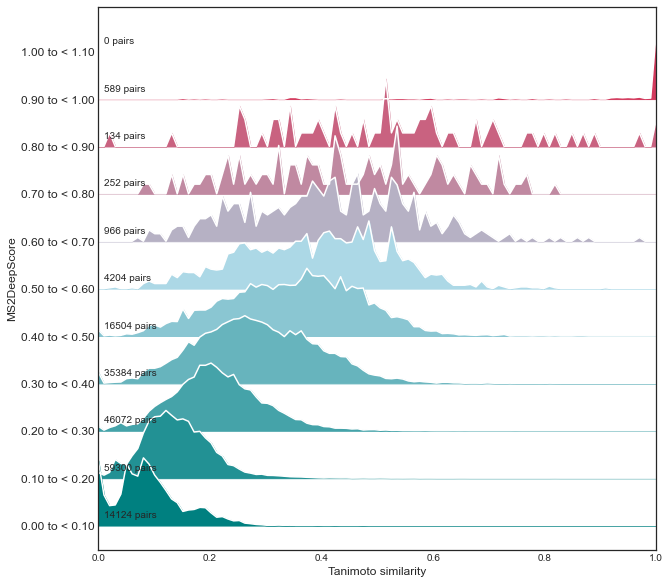

In [158]:
threshold = 0.02

create_histograms_plot(scores[scores_std < threshold], scores_ref[scores_std < threshold], n_bins=10, hist_resolution=100,
                       ref_score_name="MS2DeepScore", compare_score_name="Tanimoto similarity")

(0.0, 0.03287097325138375)

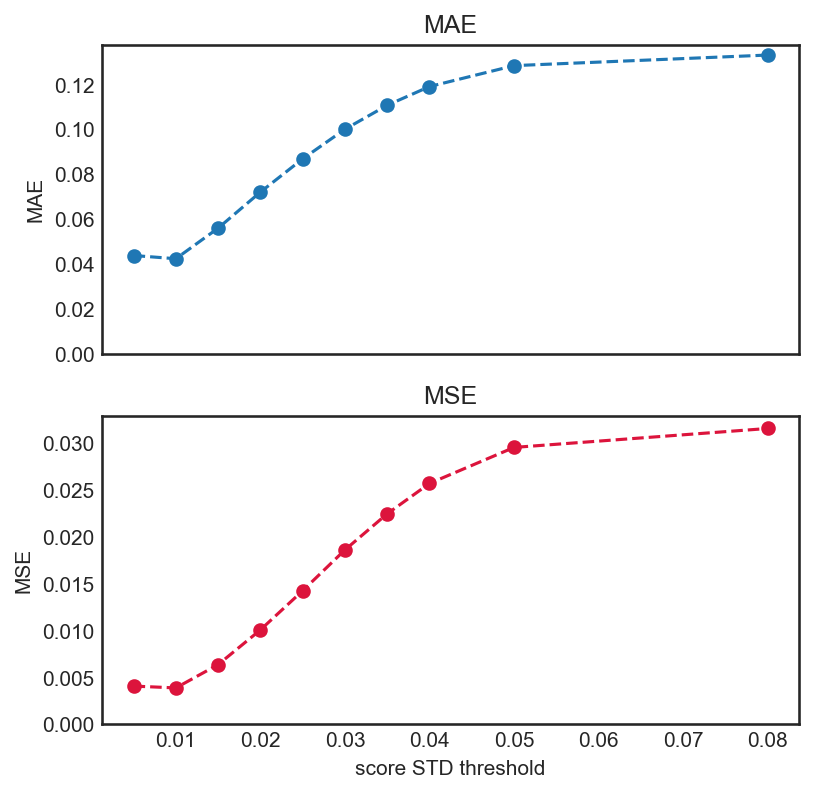

In [68]:
maes = []
mses = []
std_thresholds = [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.05, 0.08]
for thres in std_thresholds:
    maes.append(np.abs(scores_ref[scores_std < thres] - scores[scores_std < thres]).mean())
    mses.append(np.square(scores_ref[scores_std < thres] - scores[scores_std < thres]).mean())

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 6), dpi=150)
ax1.plot(std_thresholds, maes, "o--")
ax1.set_title('MAE')
ax1.set_ylabel("MAE")
ax1.set_ylim(0)

ax2.plot(std_thresholds, mses, "o--", color="crimson")
ax2.set_title('MSE')
ax2.set_ylabel("MSE")
ax2.set_xlabel("score STD threshold")
ax2.set_ylim(0)

In [127]:
std_histograms = []
std_medians = []
std_means = []
std_bins = np.linspace(0, scores_std.max(), 100)

for (a, b) in same_prob_bins:
    idx = np.where((scores > a) & (scores < b))[0]
    c, d = np.histogram(scores_std[idx], std_bins)
    std_histograms.append(c)
    std_medians.append(np.median(scores_std[idx]))
    std_means.append(np.mean(scores_std[idx]))

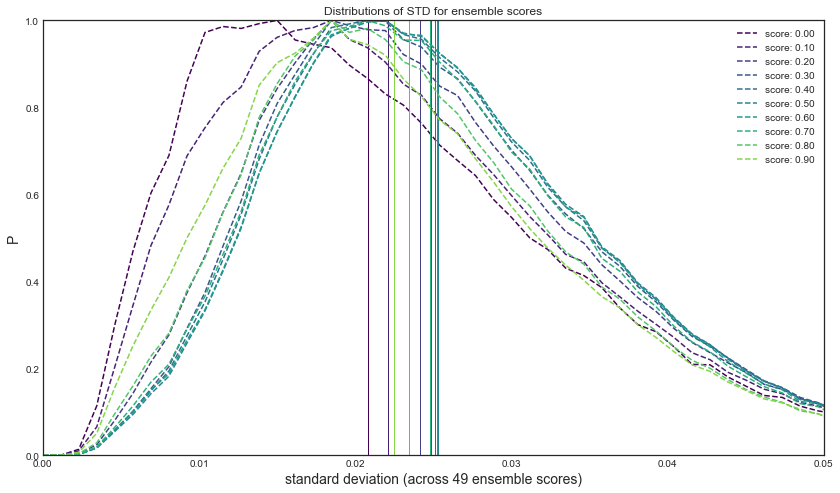

In [176]:
plt.figure(figsize=(14,8))
plt.style.use('seaborn-white')

colors = plt.cm.viridis(np.linspace(0,1,2+len(std_histograms)))

for i, d in enumerate(std_histograms):
    plt.plot(std_bins[:-1], d/np.max(d), color=colors[i], linestyle='dashed', label=f"score: {same_prob_bins[i][0]:.2f}")
    plt.axvline(std_medians[i], color=colors[i], linestyle='solid', linewidth=1)

plt.title("Distributions of STD for ensemble scores")
plt.xlabel("standard deviation (across 49 ensemble scores)", fontsize=14)
plt.ylabel("P", fontsize=14)
plt.xlim([0, 0.05])
plt.ylim([0, 1])
plt.legend()

(0.015, 0.026)

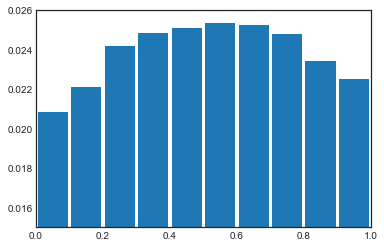

In [157]:
plt.bar([0.05 + same_prob_bins[i][0] for i in range(10)], std_medians, 0.09)
plt.xlim([0,1])
plt.ylim([0.015, 0.026])

In [96]:
c

array([ 1353, 13467, 28303, 40692, 54077, 67764, 76136, 80815, 77639,
       72896, 64738, 58118, 48976, 41035, 34696, 29109, 23982, 18959,
       15411, 11800,  9735,  7741,  5556,  4537,  3488,  2601,  1871,
        1437,  1148,   824,   589,   414,   306,   265,   185,   167,
         132,    87,   102,    49,    41,    39,    22,    26,     9,
           9,    10,     2,     9,    13], dtype=int64)

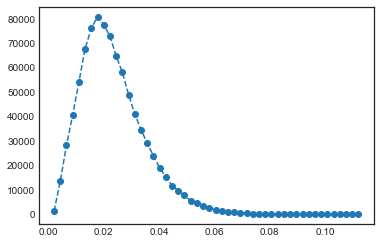

In [95]:
plt.plot(d[:-1], c, "o--")

In [82]:
idx = np.where((scores >= a) & (scores < b))[0]
idx

array([  0,   0,   0, ..., 722, 722, 723], dtype=int64)

# Train smaller network

## Convert spectra into binned spectra and peak dicts (FIXED BINS)

In [17]:
from spectrum_binning_fixed import create_peak_list_fixed, set_d_bins_fixed, unique_peaks_fixed

In [159]:
# Set binning --> FIXED BINS
number_of_bins = 10000
mz_max = 1000.0
mz_min = 10.0

d_bins = set_d_bins_fixed(number_of_bins, mz_min=mz_min, mz_max=mz_max)
print("d_bins:", d_bins)

d_bins: 0.099


In [160]:
class_values, unique_peaks = unique_peaks_fixed(spectrums_annotated, d_bins, mz_min)
vector_dim = len(unique_peaks)
print("Vector dimension:", vector_dim)

Vector dimension: 9998


In [161]:
# just checking...
from spectrum_binning_fixed import bin_number_fixed, bin_number_array_fixed
mz = np.array([10, 10.051, 10.11, 10.2, 15, 100, 1000])
bin_number_array_fixed(mz, d_bins, mz_min=mz_min)

array([    0,     0,     1,     2,    50,   909, 10000])

In [162]:
spectrums_binned = create_peak_list_fixed(spectrums_annotated, class_values,
                                          d_bins, mz_min=mz_min)
spectrums_binned_dicts = [create_peak_dict(spec) for spec in spectrums_binned]

In [163]:
count_bin_filling = []
for spec in spectrums_binned[:1000]:
    count_bin_filling += [x[0] for x in spec]

(array([ 24919.,  59485.,  67680.,  65502.,  73261., 103366.,  91688.,
         74056.,  63107.,  57388.,  52138.,  47319.,  44959.,  41898.,
         40832.,  37023.,  27006.,  23809.,  21087.,  17134.,  14686.,
         11302.,   9818.,   9078.,   8447.]),
 array([ 100.  ,  495.88,  891.76, 1287.64, 1683.52, 2079.4 , 2475.28,
        2871.16, 3267.04, 3662.92, 4058.8 , 4454.68, 4850.56, 5246.44,
        5642.32, 6038.2 , 6434.08, 6829.96, 7225.84, 7621.72, 8017.6 ,
        8413.48, 8809.36, 9205.24, 9601.12, 9997.  ]),
 <BarContainer object of 25 artists>)

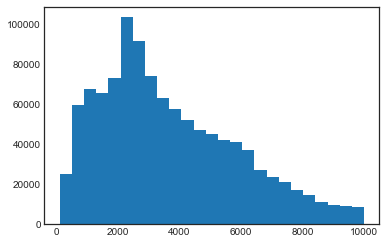

In [164]:
plt.hist(count_bin_filling, 25)

## Data generator for more balanced training data

In [23]:
#from data_generators import DataGenerator_all

In [165]:
same_prob_bins = list(zip(0.1*np.arange(10), (0.1 + 0.1*np.arange(10))))

train_generator = DataGenerator_all(spectrums_binned_dicts, train_IDs_all, trainIDs, 
                                              score_array=scores_mol_similarity, peak_scaling=0.5,
                                              batch_size=25, num_turns=1, dim=(vector_dim), shuffle=True,
                                              ignore_equal_pairs=True,
                                              inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                              same_prob_bins=same_prob_bins,
                                              augment_peak_removal={"max_removal": 0.3, "max_intensity": 0.2},
                                              augment_intensity=0.4)

val_generator = DataGenerator_all(spectrums_binned_dicts, val_IDs_all, valIDs, 
                                            score_array=scores_mol_similarity, peak_scaling=0.5,
                                            batch_size=25, num_turns=1, dim=(vector_dim), shuffle=True,
                                            ignore_equal_pairs=True,
                                            inchikey_mapping=metadata, inchikeys_array = inchikeys_array,
                                            same_prob_bins=same_prob_bins,
                                            augment_peak_removal={"max_removal": 0.01, "max_intensity": 0.01},
                                            augment_intensity=0.1)

- BatchNOrmalization
- Dropout (0.25)
- No other regularization

In [167]:
dense_dims = [600, 500, 500, 400]
dropout_rate = 0.25
print("Vector dimension:", vector_dim)

# Encoder network
input_data  = Input(shape = (vector_dim), name="encoder_input")
encoding = Dense(dense_dims[0], activation = 'relu', #kernel_regularizer=tf.keras.regularizers.l1(1e-6),
                 name="dense_101")(input_data)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[1], activation = 'relu', name="dense_102")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[2], activation = 'relu', name="dense_103")(encoding)
encoding = BatchNormalization()(encoding)
encoding = Dropout(dropout_rate)(encoding)
encoding = Dense(dense_dims[3], activation = 'relu', name="dense_104",
                 #activity_regularizer=tf.keras.regularizers.l2(0.001),
                )(encoding)

encoder = Model(input_data, encoding)

# Scoring network
spectrum1 = Input(shape = (vector_dim), name="scoring_input1")
spectrum2 = Input(shape = (vector_dim), name="scoring_input2")

embedding1 = encoder(spectrum1)
embedding2 = encoder(spectrum2)

cosine_similarity = Dot(axes=(1, 1), normalize=True, name="cosine_similarity")([embedding1, embedding2])

scoring_network = Model(inputs=[spectrum1, spectrum2], outputs = [cosine_similarity])

scoring_network.summary()
encoder.summary()

Vector dimension: 9998
Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scoring_input1 (InputLayer)     [(None, 9998)]       0                                            
__________________________________________________________________________________________________
scoring_input2 (InputLayer)     [(None, 9998)]       0                                            
__________________________________________________________________________________________________
functional_9 (Functional)       (None, 400)          6757200     scoring_input1[0][0]             
                                                                 scoring_input2[0][0]             
__________________________________________________________________________________________________
cosine_similarity (Dot)         (None, 1)            0         

In [168]:
epochs = 150
learning_rate = 0.002 #0.001
metrics = ["mae"]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

# Parameters
patience_scoring_net = 10
scoring_network_output_file = "scoring_network_201123_All_cosine_medium_fixedBins.hdf5"

scoring_network.compile(
    loss='mse',
    optimizer=Adam(lr=learning_rate),
    metrics=metrics)

checkpointer = ModelCheckpoint(
    filepath = scoring_network_output_file,
    monitor='val_loss', mode="min",
    verbose=1,
    save_best_only=True
    )

earlystopper_scoring_net = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=patience_scoring_net,
    verbose=1
    )

history = scoring_network.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    epochs = epochs,
    callbacks = [
        earlystopper_scoring_net,
        checkpointer,
        ]
    )

Epoch 1/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0594 - mae: 0.1919
Epoch 00001: val_loss improved from inf to 0.06111, saving model to scoring_network_201123_All_cosine_medium_fixedBins.hdf5
2798/2798 [==============================] - 1008s 360ms/step - loss: 0.0594 - mae: 0.1919 - val_loss: 0.0611 - val_mae: 0.1929
Epoch 2/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0497 - mae: 0.1725
Epoch 00002: val_loss improved from 0.06111 to 0.05296, saving model to scoring_network_201123_All_cosine_medium_fixedBins.hdf5
2798/2798 [==============================] - 825s 295ms/step - loss: 0.0497 - mae: 0.1725 - val_loss: 0.0530 - val_mae: 0.1774
Epoch 3/150
2798/2798 [==============================] - ETA: 0s - loss: 0.0449 - mae: 0.1629
Epoch 00003: val_loss improved from 0.05296 to 0.05093, saving model to scoring_network_201123_All_cosine_medium_fixedBins.hdf5
2798/2798 [==============================] - 840s 300ms/step - loss: 0.0449 - mae: 

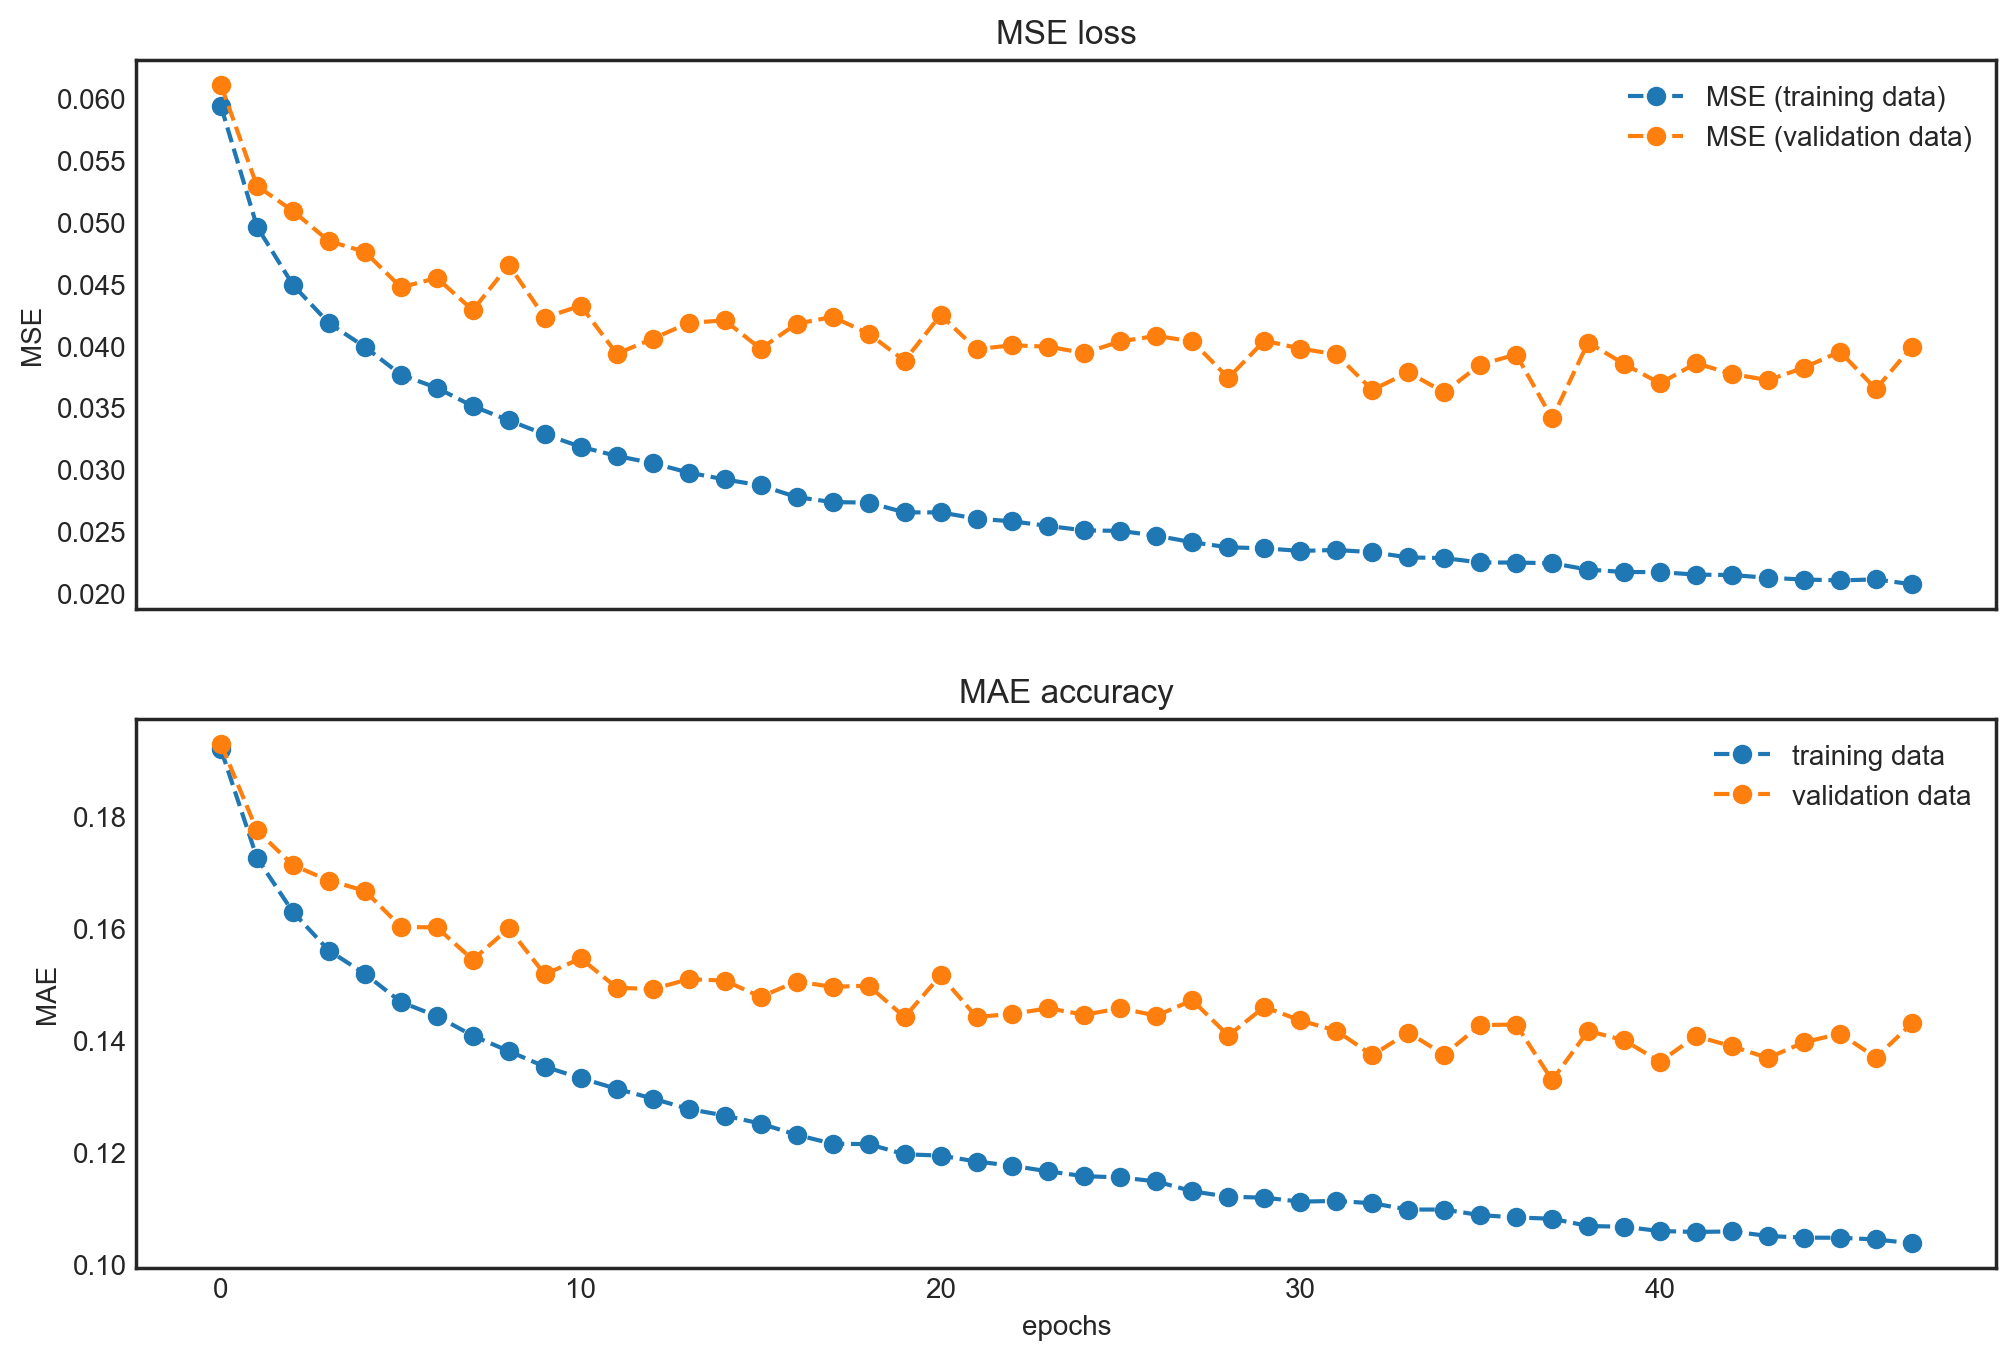

In [169]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,8), dpi=200)

ax1.plot(history.history['loss'], "o--", label='MSE (training data)')
ax1.plot(history.history['val_loss'], "o--", label='MSE (validation data)')
ax1.set_title('MSE loss')
ax1.set_ylabel("MSE")
ax1.legend()

ax2.plot(history.history['mae'], "o--", label='training data')
ax2.plot(history.history['val_mae'], "o--", label='validation data')
ax2.set_title('MAE accuracy')
ax2.set_ylabel("MAE")
ax2.set_xlabel("epochs")
ax2.legend()

In [170]:
embeddings = get_embedding_array(testIDs, 400, encoder, metadata, inchikeys_array, peak_scaling=0.5)

In [171]:
MS2DS_scores = cosine_similarity_matrix(embeddings, embeddings)

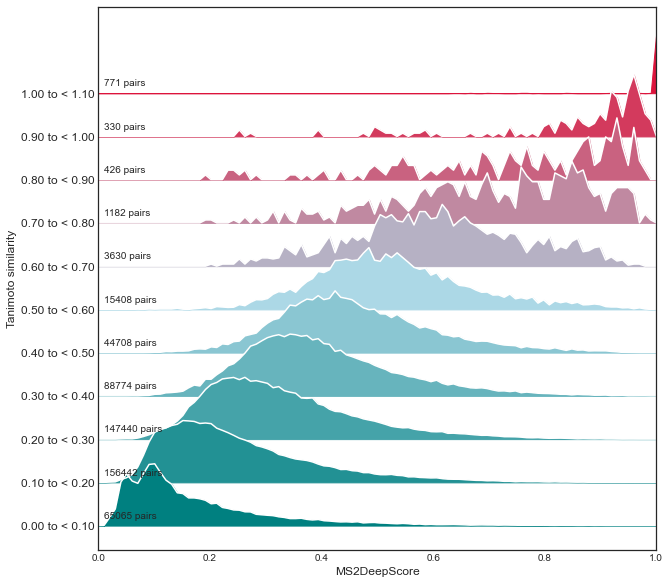

In [172]:
create_histograms_plot(scores_ref, MS2DS_scores, n_bins=10, hist_resolution=100,
                       ref_score_name="Tanimoto similarity", compare_score_name="MS2DeepScore")

# Conclusion 
- does not generalize well (missing l1 regularization and/or size?)
- however: reaches lower loss than in larger network above